In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
import cv2
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
import glob
import keras.backend as K

K.clear_session() # 새로운 세션으로 시작

### 사진 사이즈

In [2]:
height = 224
width = 224

### 이미지 파일 불러오는 함수

In [3]:
def img_read_resize(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (height, width))
    return img

In [4]:
""" 
목적 : 폴더별 이미지 읽어오는 함수/ 특정 폴더에 있는 이미지를 array 형태로 읽어와서 리스트에 담아주는 함수
형식에 맞지 않는 이미지는 제외하고 가져오도록 try, except 를 사용
"""
def img_folder_read(root_dir):
    img_files = []
    nfiles = glob.glob(f"{root_dir}/*")
    nfiles = sorted(nfiles)
    for n_img in nfiles:
        try:
            img_files.append(img_read_resize(n_img))
        except:
            continue
    return img_files

### f1-score 구하는 함수

In [5]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


### 테스트 데이터 할당

In [6]:
test_root_dir = "img_data/test_imgs"
test_root_dir

'img_data/test_imgs'

In [7]:
test_generator = img_folder_read(test_root_dir)
test_generator

[array([[[244, 244, 244],
         [244, 244, 244],
         [244, 244, 244],
         ...,
         [242, 242, 239],
         [244, 244, 244],
         [240, 239, 241]],
 
        [[244, 244, 244],
         [244, 244, 244],
         [243, 242, 243],
         ...,
         [244, 244, 244],
         [244, 244, 244],
         [244, 244, 244]],
 
        [[244, 244, 244],
         [244, 244, 244],
         [244, 244, 244],
         ...,
         [244, 244, 244],
         [244, 244, 244],
         [244, 244, 244]],
 
        ...,
 
        [[244, 244, 243],
         [240, 241, 240],
         [242, 243, 242],
         ...,
         [243, 243, 243],
         [240, 240, 241],
         [241, 241, 241]],
 
        [[243, 243, 243],
         [241, 241, 241],
         [241, 242, 242],
         ...,
         [242, 242, 242],
         [243, 243, 242],
         [242, 242, 242]],
 
        [[243, 243, 242],
         [241, 241, 241],
         [241, 242, 242],
         ...,
         [243, 243, 243],
  

In [8]:
test_generator[0]

array([[[244, 244, 244],
        [244, 244, 244],
        [244, 244, 244],
        ...,
        [242, 242, 239],
        [244, 244, 244],
        [240, 239, 241]],

       [[244, 244, 244],
        [244, 244, 244],
        [243, 242, 243],
        ...,
        [244, 244, 244],
        [244, 244, 244],
        [244, 244, 244]],

       [[244, 244, 244],
        [244, 244, 244],
        [244, 244, 244],
        ...,
        [244, 244, 244],
        [244, 244, 244],
        [244, 244, 244]],

       ...,

       [[244, 244, 243],
        [240, 241, 240],
        [242, 243, 242],
        ...,
        [243, 243, 243],
        [240, 240, 241],
        [241, 241, 241]],

       [[243, 243, 243],
        [241, 241, 241],
        [241, 242, 242],
        ...,
        [242, 242, 242],
        [243, 243, 242],
        [242, 242, 242]],

       [[243, 243, 242],
        [241, 241, 241],
        [241, 242, 242],
        ...,
        [243, 243, 243],
        [242, 243, 242],
        [242, 242, 242]]

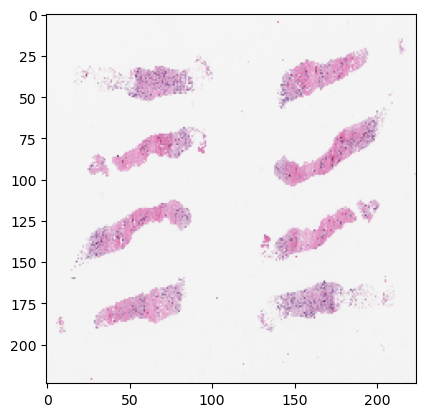

In [9]:
plt.imshow(test_generator[100])

In [10]:
test_arr = np.array(test_generator)

In [11]:
test = test_arr/255

### 트레이닝 데이터 할당

In [12]:
data_generator = ImageDataGenerator(rescale = 1./255, validation_split=0.3)

In [13]:
train_generator = data_generator.flow_from_directory(
    directory = "img_data/train_imgs",
    target_size = (height,width),
    batch_size = 10,
    class_mode = 'binary',
    subset = 'training',
    shuffle = False)

Found 701 images belonging to 2 classes.


In [14]:
train_generator.class_indices

{'notransfer': 0, 'transfer': 1}

In [15]:
val_generator = data_generator.flow_from_directory(
    directory = "img_data/train_imgs",
    target_size =(height, width),
    class_mode = 'binary',
    batch_size = 10,
    subset='validation',
    shuffle = False)

Found 299 images belonging to 2 classes.


In [16]:
# 수작업으로 레이어 생성
'''
model = Sequential()
# 입력층
model.add(Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu', input_shape=(height, width, 3)))
model.add(MaxPool2D(pool_size = (2,2), strides = 1))
model.add(Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size = (2,2), strides = 1))
model.add(Dropout(0.2))
# Fully-connected layer
model.add(Flatten())
model.add(Dense(units = 32, activation = 'relu'))

# 출력층 - binary classification
model.add(Dense(1, activation='sigmoid'))
'''

"\nmodel = Sequential()\n# 입력층\nmodel.add(Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu', input_shape=(height, width, 3)))\nmodel.add(MaxPool2D(pool_size = (2,2), strides = 1))\nmodel.add(Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu'))\nmodel.add(MaxPool2D(pool_size = (2,2), strides = 1))\nmodel.add(Dropout(0.2))\n# Fully-connected layer\nmodel.add(Flatten())\nmodel.add(Dense(units = 32, activation = 'relu'))\n\n# 출력층 - binary classification\nmodel.add(Dense(1, activation='sigmoid'))\n"

In [17]:
# vgg 사용
from tensorflow.keras.applications.vgg16 import VGG16
vgg = VGG16(weights = "imagenet", include_top=False, input_shape =(height, width, 3))

model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation = "sigmoid"))

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-12-26 14:13:15.783542: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-26 14:13:15.784103: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [18]:
# summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1024)              25691136  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 40,406,849
Trainable params: 40,406,849
Non-trainable params: 0
_________________________________________________________________


In [19]:
# compile
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])

In [20]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_f1_m', patience=2)

In [22]:
history = model.fit(train_generator, epochs = 5, callbacks = early_stop, validation_data = val_generator)

Epoch 1/5


2022-12-26 14:15:55.537057: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-26 14:15:56.117101: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


71/71 [==============================] - ETA: 0s - loss: 12.3914 - acc: 0.4365 - f1_m: 0.1818 - precision_m: 0.4930 - recall_m: 0.1507

2022-12-26 14:18:17.634350: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


71/71 [==============================] - 196s 3s/step - loss: 12.3914 - acc: 0.4365 - f1_m: 0.1818 - precision_m: 0.4930 - recall_m: 0.1507 - val_loss: 0.6933 - val_acc: 0.4849 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/5
71/71 [==============================] - 191s 3s/step - loss: 0.6940 - acc: 0.4850 - f1_m: 0.0986 - precision_m: 0.4789 - recall_m: 0.0606 - val_loss: 0.6932 - val_acc: 0.4849 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/5
71/71 [==============================] - 191s 3s/step - loss: 0.6940 - acc: 0.4936 - f1_m: 0.1147 - precision_m: 0.5070 - recall_m: 0.0718 - val_loss: 0.6932 - val_acc: 0.4849 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00


In [23]:
# history 를 데이터프레임으로 만듭니다.
df_hist = pd.DataFrame(history.history)
df_hist.tail()

,loss,acc,f1_m,precision_m,recall_m,val_loss,val_acc,val_f1_m,val_precision_m,val_recall_m
0,12.391376,0.436519,0.181818,0.492958,0.150704,0.693293,0.48495,0.0,0.0,0.0
1,0.694014,0.485021,0.098592,0.478873,0.060563,0.693246,0.48495,0.0,0.0,0.0
2,0.694025,0.493581,0.114688,0.507042,0.071831,0.693152,0.48495,0.0,0.0,0.0


<AxesSubplot: >

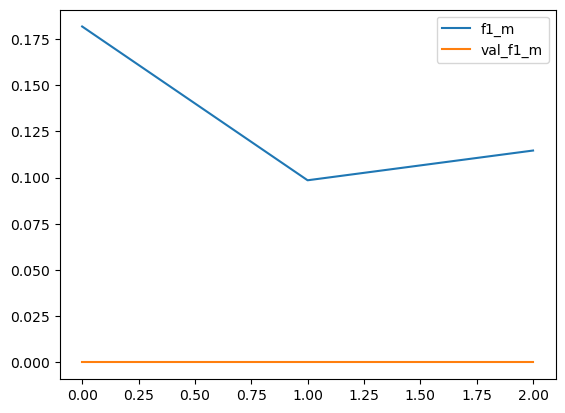

In [24]:
df_hist[["f1_m","val_f1_m"]].plot()

### 모델 예측

In [25]:
y_pred = model.predict(test)

2022-12-26 14:26:37.548170: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 5s 529ms/step


In [26]:
y_predict = (y_pred.flatten() > 0.5).astype(int)
y_predict[:5]

array([0, 0, 0, 0, 0])

In [29]:
submission = pd.read_csv("csv_data/sample_submission.csv")
submission.head()

,ID,N_category
0,BC_01_0011,0
1,BC_01_0220,0
2,BC_01_0233,0
3,BC_01_0258,0
4,BC_01_0260,0


In [30]:
submission["N_category"] = y_predict
submission["N_category"].head()

0    0
1    0
2    0
3    0
4    0
Name: N_category, dtype: int64

In [32]:
score = float(df_hist["val_acc"][-1:])
score

0.48494982719421387

In [33]:
file_name = f"submission/{score:.5f}.csv"
file_name

'submission/0.48495.csv'

In [ ]:
submission.to_csv(file_name, index = False)

In [ ]:
pd.read_csv(file_name)

,ID,N_category
0,BC_01_0011,1
1,BC_01_0220,1
2,BC_01_0233,1
3,BC_01_0258,1
4,BC_01_0260,1
...,...,...
245,BC_01_3328,1
246,BC_01_3404,1
247,BC_01_3418,1
248,BC_01_3438,1
